# Create Tiles

The first thing we need to do is to create the tiles. We are going to create 1deg tiles.
The raster to be used as example is a DEM corrected for forests heights released by the Brazilian National Water and Sanitation Agency, called ANADEM.
This DEM was originally published as a single GeoTIFF file with almost 200Gb of size, making it difficult to manipulate. 

For this tutorial, instead of working with the entire TIFF, I will use a croped version with the South region of Brazil. However, the same procedure can be replicated for any other GeoTiff. 

We will use Rasterio to perform the operations. 

## Open the GeoTiff

Considering we are working with large files, here we are going to read just a downscaled version of it. As `rioxarray` does not support decimated reading, I've created a helper function that takes the desired output shape as argument and it loads just the "necessary" pixels to return an `xarray`'s `DataArray`. 

In [86]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as xrio
import xarray as xr

In [93]:
def decimated_reading(file, out_shape):

    # Open the dataset with rasterio
    ds = rio.open(file)

    # Read it with the desired output shape (decimated reading)
    data=ds.read(out_shape=out_shape).squeeze()
    data[data == ds.nodata] = np.nan

    # create the lats and longs coordinates, considering the bounds and the shape
    longs = np.linspace(ds.bounds.left, ds.bounds.right, out_shape[1])
    lats = np.linspace(ds.bounds.top, ds.bounds.bottom, out_shape[0])

    arr = xr.DataArray(data=data, dims=['y', 'x'], coords=[lats, longs])

    # set CRS and GeoTransform
    arr.rio.set_crs(ds.crs)
    transform = rio.transform.from_bounds(*ds.bounds, height=out_shape[0], width=out_shape[1])
    arr = arr.rio.write_transform(transform)

    return arr

In [94]:
arr = decimated_reading('/data/anadem_v018/anadem_south_2.tif', out_shape=(420, 360))
arr

<xarray.DataArray (y: 420, x: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 -22.51 -22.53 -22.56 ... -33.71 -33.73 -33.76
  * x            (x) float64 -57.66 -57.63 -57.61 ... -48.07 -48.04 -48.01
    spatial_ref  int64 0

Now, let's simulate the tiling by using Geopandas. The tiling we want takes 1x1 degree in lat and long. 
Additionally, to avoid creating data where there is no data, let's test it like so:

In [96]:
xmin, ymin, xmax, ymax = arr.rio.bounds()

In [98]:
import math

In [107]:
min_lon = math.floor(xmin)
max_lon = math.ceil(xmax)
min_lat = math.floor(ymin)
max_lat = math.ceil(ymax)
(min_lon, max_lon), (min_lat, max_lat)

((-58, -48), (-34, -22))

In [134]:
# create the tiles
from shapely.geometry import box
tiles = []
for lon in range(min_lon, max_lon):
    for lat in range(min_lat, max_lat):

        tile = box(lon, lat, lon+1, lat+1)

        # test if there is valid data within the tile
        tile_arr = arr.sel(x=slice(tile.bounds[0], tile.bounds[2]), y=slice(tile.bounds[3], tile.bounds[1]))

        if not tile_arr.isnull().all():
            tiles.append(tile)

In [135]:
import geopandas as gpd

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

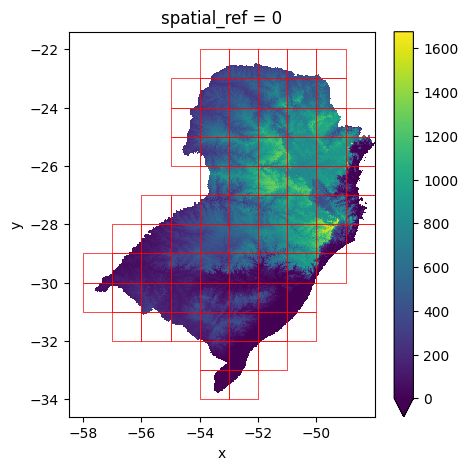

In [136]:
fig, ax = plt.subplots(figsize=(5, 5))
arr.plot.imshow(vmin=0, ax=ax)
gpd.GeoDataFrame(geometry=tiles).plot(facecolor='none', edgecolor='red', linewidth=0.5, ax=ax)


In [121]:
tile = tiles[0]

In [129]:
tile_arr = arr.sel(x=slice(tile.bounds[0], tile.bounds[2]), y=slice(tile.bounds[3], tile.bounds[1]))

In [132]:
~tile_arr.isnull().all()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

In [109]:
box?

Signature: box(minx, miny, maxx, maxy, ccw=True)
Docstring: Returns a rectangular polygon with configurable normal vector
File:      /usr/local/lib/python3.10/dist-packages/shapely/geometry/geo.py
Type:      function

In [6]:
ds = xrio.open_rasterio('/data/anadem_v018/anadem_south_2.tif', masked=True)
ds

<xarray.DataArray (band: 1, y: 41762, x: 35793)>
[1494787266 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -57.66 -57.66 -57.66 ... -48.01 -48.01 -48.01
  * y            (y) float64 -22.51 -22.51 -22.51 ... -33.76 -33.76 -33.76
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [29]:
downscaled = ds.rio.reproject(dst_crs=ds.rio.crs, shape=(415, 357))

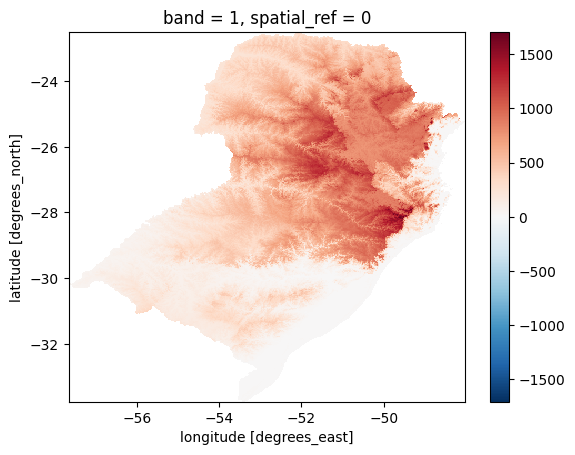

In [31]:
downscaled.plot()

In [3]:
import xarray as xr

In [64]:
ds.close()

In [81]:
# %%timeit -r1 -n1

# Open the dataset
ds = rio.open('/data/anadem_v018/anadem_south_2.tif')
print(ds.bounds)
print(ds.shape)

# set the desired output shape to use (decimated reading)
out_shape = (4170, 3570)
data=ds.read(out_shape=out_shape).squeeze()
data[data == ds.nodata] = np.nan

# create the lats and longs coordinates, considering the bounds and the shape
longs = np.linspace(ds.bounds.left, ds.bounds.right, out_shape[1])
lats = np.linspace(ds.bounds.top, ds.bounds.bottom, out_shape[0])

array = xr.DataArray(data=data, dims=['lat', 'long'], coords=[lats, longs])

# ds.close()

BoundingBox(left=-57.65971398413766, bottom=-33.76093416542192, right=-48.01369429479065, top=-22.506301296802086)
(41762, 35793)


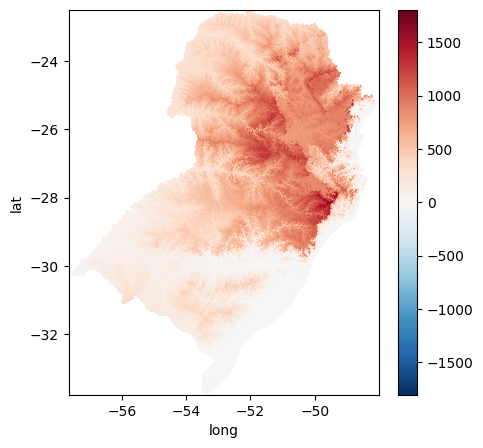

In [83]:
array.plot.imshow(aspect=1, figsize=(5, 5))

In [67]:
ds.compression

<Compression.deflate: 'DEFLATE'>

In [6]:
rio.open?

Signature:
rio.open(
    fp,
    mode='r',
    driver=None,
    width=None,
    height=None,
    count=None,
    crs=None,
    transform=None,
    dtype=None,
    nodata=None,
    sharing=False,
    **kwargs,
)
Docstring:
Open a dataset for reading or writing.

The dataset may be located in a local file, in a resource located by
a URL, or contained within a stream of bytes.

In read ('r') or read/write ('r+') mode, no keyword arguments are
required: these attributes are supplied by the opened dataset.

In write ('w' or 'w+') mode, the driver, width, height, count, and dtype
keywords are strictly required.

Parameters
----------
fp : str, file object, PathLike object, FilePath, or MemoryFile
    A filename or URL, a file object opened in binary ('rb') mode, a
    Path object, or one of the rasterio classes that provides the
    dataset-opening interface (has an open method that returns a
    dataset).
mode : str, optional
    'r' (read, the default), 'r+' (read/write), 'w' (write), or
 

Notice the raster is still huge with aprox. 40kx40k pixels. Thanks to decimated reading (more on that on a future post), we can quickly display a downscaled version of it. 

In [63]:
arr = ds.read(out_shape=(417, 357)).squeeze()
arr[arr == ds.nodata] = np.nan

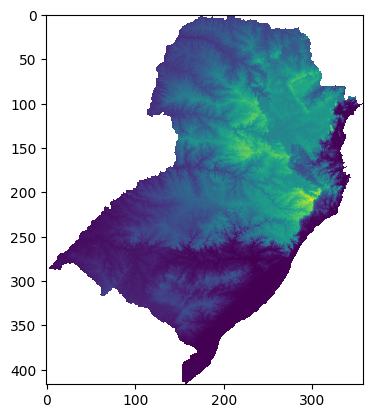

In [64]:
ax = plt.imshow(arr)

In [61]:
ax.set_ylim(0, 100)

AttributeError: 'AxesImage' object has no attribute 'set_ylim'

In [60]:
ax.get_extent()

[-0.5, 356.5, 416.5, -0.5]

In [50]:
ds.dataset_mask(out_shape=(417, 357))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)